In [64]:
from itertools import count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from snowballstemmer import algorithms

import bus_indentifier
from bus_indentifier import Eta, BusLineEta

from ortools.linear_solver import pywraplp

In [63]:
# Reimport the bus_indentifier module to get the latest changes
importlib.reload(bus_indentifier)


<module 'bus_indentifier' from 'F:\\gitRepository\\hk-bus\\scheduling\\bus_indentifier.py'>

In [65]:
# Load the data
data = pd.read_csv('../data/input/test/oneLineOneDayETA.csv')
data

,co,time,route,dir,service_type,seq,dest,eta_seq,eta,rmk,timestamp
0,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),1,2024-09-18T10:37:00+08:00,原定班次,2024-09-18T10:33:16+08:00
1,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),2,2024-09-18T10:45:00+08:00,原定班次,2024-09-18T10:33:16+08:00
2,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),3,2024-09-18T10:52:00+08:00,原定班次,2024-09-18T10:33:16+08:00
3,KMB,2024-09-18-10-33-25,278K,O,1,2,粉嶺站(循環線),1,2024-09-18T10:37:00+08:00,原定班次,2024-09-18T10:33:16+08:00
4,KMB,2024-09-18-10-33-25,278K,O,1,2,粉嶺站(循環線),2,2024-09-18T10:45:00+08:00,原定班次,2024-09-18T10:33:16+08:00
...,...,...,...,...,...,...,...,...,...,...,...
1858,KMB,2024-09-18-17-12-38,278K,O,1,8,粉嶺站(循環線),2,2024-09-18T17:24:43+08:00,原定班次,2024-09-18T17:12:13+08:00
1859,KMB,2024-09-18-17-12-38,278K,O,1,8,粉嶺站(循環線),3,2024-09-18T17:34:43+08:00,原定班次,2024-09-18T17:12:13+08:00
1860,KMB,2024-09-18-17-12-38,278K,O,1,9,粉嶺站(循環線),4,2024-09-18T17:16:42+08:00,NaN,2024-09-18T17:12:13+08:00
1861,KMB,2024-09-18-17-12-38,278K,O,1,9,粉嶺站(循環線),5,2024-09-18T17:26:34+08:00,原定班次,2024-09-18T17:12:13+08:00


In [66]:
# Convert the 'eta' col into datetime
data['eta'] = pd.to_datetime(data['eta'])
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,co,time,route,dir,service_type,seq,dest,eta_seq,eta,rmk,timestamp
0,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),1,2024-09-18 10:37:00+08:00,原定班次,2024-09-18 10:33:16+08:00
1,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),2,2024-09-18 10:45:00+08:00,原定班次,2024-09-18 10:33:16+08:00
2,KMB,2024-09-18-10-33-25,278K,O,1,1,粉嶺站(循環線),3,2024-09-18 10:52:00+08:00,原定班次,2024-09-18 10:33:16+08:00
3,KMB,2024-09-18-10-33-25,278K,O,1,2,粉嶺站(循環線),1,2024-09-18 10:37:00+08:00,原定班次,2024-09-18 10:33:16+08:00
4,KMB,2024-09-18-10-33-25,278K,O,1,2,粉嶺站(循環線),2,2024-09-18 10:45:00+08:00,原定班次,2024-09-18 10:33:16+08:00
...,...,...,...,...,...,...,...,...,...,...,...
1858,KMB,2024-09-18-17-12-38,278K,O,1,8,粉嶺站(循環線),2,2024-09-18 17:24:43+08:00,原定班次,2024-09-18 17:12:13+08:00
1859,KMB,2024-09-18-17-12-38,278K,O,1,8,粉嶺站(循環線),3,2024-09-18 17:34:43+08:00,原定班次,2024-09-18 17:12:13+08:00
1860,KMB,2024-09-18-17-12-38,278K,O,1,9,粉嶺站(循環線),4,2024-09-18 17:16:42+08:00,NaN,2024-09-18 17:12:13+08:00
1861,KMB,2024-09-18-17-12-38,278K,O,1,9,粉嶺站(循環線),5,2024-09-18 17:26:34+08:00,原定班次,2024-09-18 17:12:13+08:00


In [111]:
len(data.query("seq == 9"))

207

# Create Instances

In [67]:
etas = [Eta(id=idx, co=row.co, line_id=row.route, dir=row.dir, service_type=row.service_type, seq=row.seq,
            dest=row.dest,eta_seq=row.eta_seq, eta=row.eta, rmk=row.rmk, scrapped_time=row.timestamp) 
            for idx, row in data.iterrows()]
lines = [BusLineEta(co=etas[0].co ,etas=etas, line_id=etas[0].line_id, dir=etas[0].dir, service_type=etas[0].service_type, dest=etas[0].dest, rmk=etas[0].rmk)]

In [68]:
testLine = lines[0]
# testLine.eta_groups
sum([len(_group) for _idx, _group in testLine.eta_groups.items()])

1863

In [69]:
testLine.clean_etas(time_threshold=5)

In [70]:
sum([len(_group) for _idx, _group in testLine.eta_groups.items()])

471

In [71]:
sorted([eta.eta for eta in testLine.eta_groups.get(9)])

[Timestamp('2024-09-18 10:35:32+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 10:43:43+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 10:51:32+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:03:09+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:04:01+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:06:07+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:07:31+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:17:42+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:20:59+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:22:32+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:32:38+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:35:45+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:36:46+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:49:46+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:50:34+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 11:59:34+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 12:01:05+0800', tz='UTC+08:00'),
 Timestamp('2024-09-18 12:01:51+0800', tz='UTC+0

In [72]:
len(testLine.eta_groups.get(9))

60

In [74]:
all_candidate_eta_lists, all_candidate_eta_time_gaps = testLine.find_possible_consecutive_eta_pairs()

In [81]:
all_candidate_eta_lists[0]

[[(<bus_indentifier.Eta at 0x205612f3490>,
   <bus_indentifier.Eta at 0x205612f2da0>)],
 [(<bus_indentifier.Eta at 0x205612f0460>,
   <bus_indentifier.Eta at 0x205612f2230>),
  (<bus_indentifier.Eta at 0x205612f0460>,
   <bus_indentifier.Eta at 0x205612f2da0>)],
 [(<bus_indentifier.Eta at 0x20561368910>,
   <bus_indentifier.Eta at 0x205612f0880>),
  (<bus_indentifier.Eta at 0x20561368910>,
   <bus_indentifier.Eta at 0x205612f2230>),
  (<bus_indentifier.Eta at 0x20561368910>,
   <bus_indentifier.Eta at 0x205612f2da0>)],
 [(<bus_indentifier.Eta at 0x205613696c0>,
   <bus_indentifier.Eta at 0x2056136a140>),
  (<bus_indentifier.Eta at 0x205613696c0>,
   <bus_indentifier.Eta at 0x205612f0880>),
  (<bus_indentifier.Eta at 0x205613696c0>,
   <bus_indentifier.Eta at 0x205612f2230>),
  (<bus_indentifier.Eta at 0x205613696c0>,
   <bus_indentifier.Eta at 0x205612f2da0>)],
 [(<bus_indentifier.Eta at 0x2056136bf70>,
   <bus_indentifier.Eta at 0x20561368e80>),
  (<bus_indentifier.Eta at 0x2056136bf7

In [82]:
all_candidate_eta_time_gaps[0]

[1.3166666666666667,
 9.5,
 17.316666666666666,
 28.933333333333334,
 25.116666666666667,
 29.8,
 23.716666666666665,
 26.866666666666667,
 17.966666666666665,
 19.366666666666667,
 26.666666666666668,
 16.933333333333334,
 15.916666666666666,
 18.65,
 19.45,
 24.333333333333332,
 25.85,
 19.033333333333335,
 26.616666666666667,
 17.333333333333332,
 16.25,
 18.966666666666665,
 15.666666666666666,
 13.25,
 11.783333333333333,
 12.733333333333333,
 10.683333333333334,
 20.366666666666667,
 22.3,
 21.366666666666667,
 28.016666666666666,
 26.116666666666667,
 32.266666666666666,
 41.11666666666667,
 39.766666666666666,
 42.733333333333334,
 43.516666666666666,
 40.4,
 49.46666666666667,
 40.11666666666667,
 44.03333333333333,
 40.483333333333334,
 40.68333333333333,
 19.566666666666666,
 40.68333333333333,
 30.016666666666666,
 24.116666666666667,
 34.68333333333333,
 36.6,
 37.6,
 34.85,
 30.3,
 37.31666666666667,
 51.8,
 58.18333333333333,
 48.46666666666667,
 50.483333333333334,
 49.

# Test

In [83]:
_ = [1,4,6, 2, 1.5]
_.sort()
_

[1, 1.5, 2, 4, 6]

In [132]:
a = (testLine.eta_groups.get(9)[0]).backward_search_feasible_etas(testLine.eta_groups.get(8))
a[0].eta

Timestamp('2024-09-18 10:34:13+0800', tz='UTC+08:00')

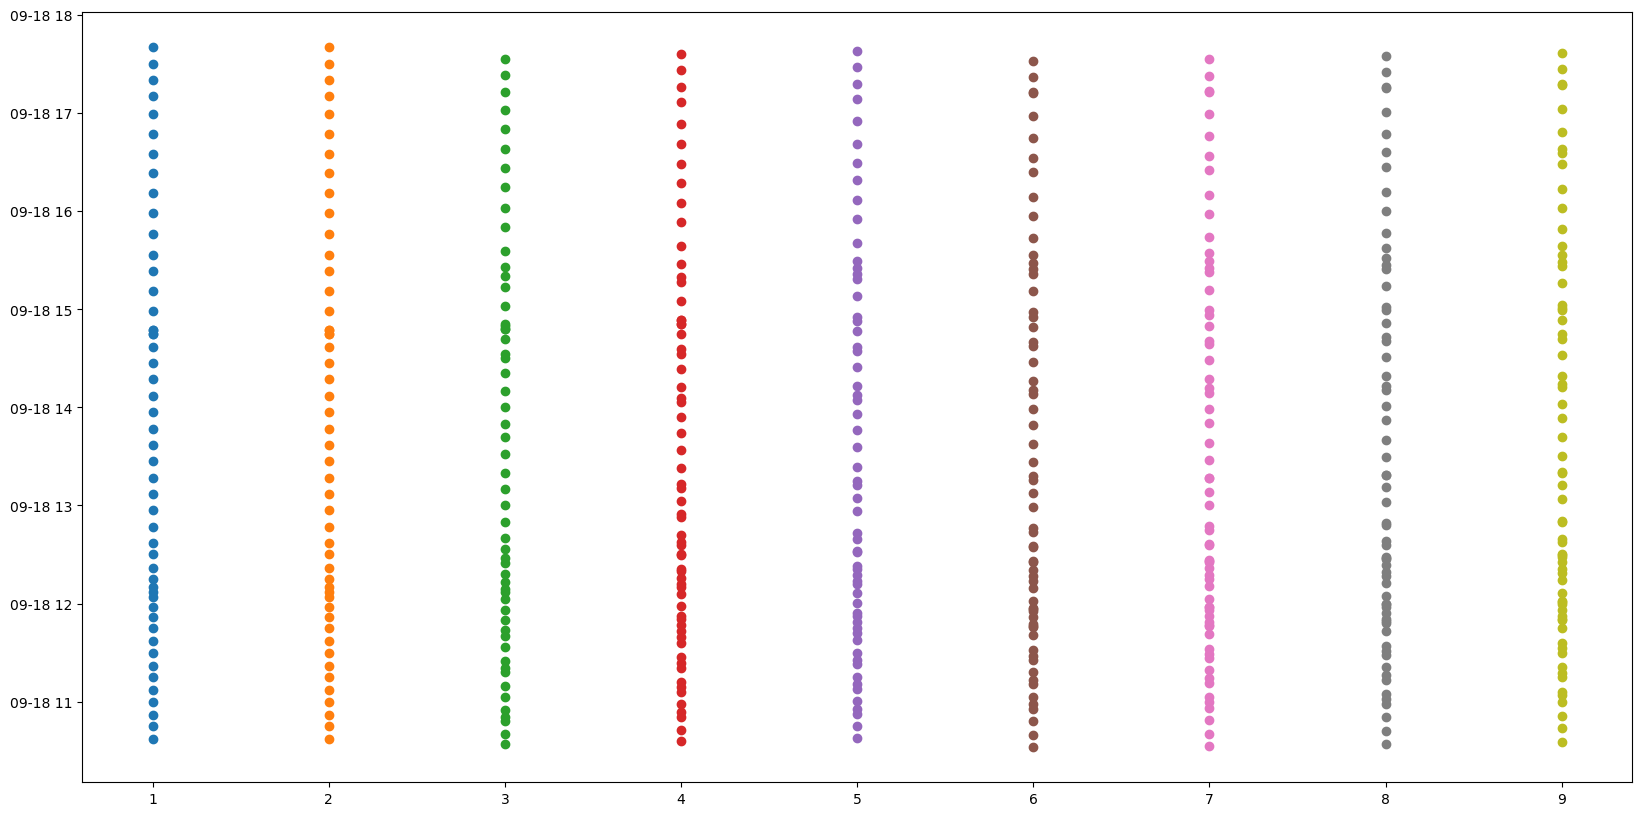

In [72]:
plot_etas = {}
for name, group in testLine.eta_groups.items():
    plot_etas[name] = [eta.eta for eta in group]

plt.figure(figsize=(20,10))
for name, group in plot_etas.items():
    plt.scatter([name]*len(group), group, label=name)


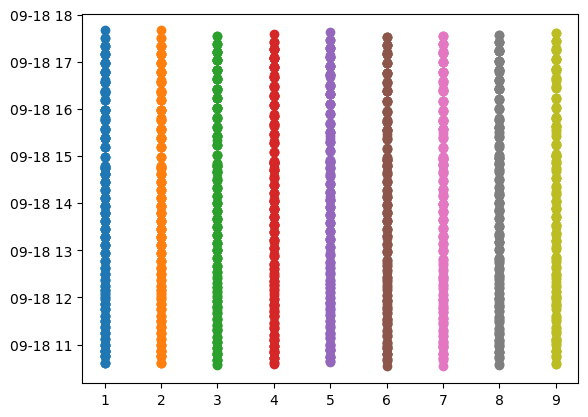

In [6]:
data_by_seq = data.groupby('seq')
# plot the eta scatter of each seq
for name, group in data_by_seq:
    plt.scatter(group['seq'], group['eta'], label=name)

In [2]:
a_eta = [10, 20, 25, 40, 50]
b_eta = [60, 40, 55, 89, 102]

In [3]:
time_diffs = []
for i, eta1 in enumerate(b_eta):
    inner_diffs = []
    for j, eta2 in enumerate(a_eta):
        if eta1 > eta2:
            inner_diffs.append(eta1 - eta2)
    time_diffs.append(inner_diffs)
time_diffs

[[50, 40, 35, 20, 10],
 [30, 20, 15],
 [45, 35, 30, 15, 5],
 [79, 69, 64, 49, 39],
 [92, 82, 77, 62, 52]]

In [4]:
var_candidates = []
for i, eta1 in enumerate(b_eta):
    inner_ = []
    for j, eta2 in enumerate(a_eta):
        if eta1 > eta2:
            inner_.append(j)
    var_candidates.append(inner_)
var_candidates

[[0, 1, 2, 3, 4], [0, 1, 2], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]

In [115]:
_ = [item for sublist in var_candidates for item in sublist]
_

[0, 0, 1, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3]

In [116]:
np.where(np.array(_) == 0)[0]

array([0, 1, 3, 5, 9], dtype=int64)

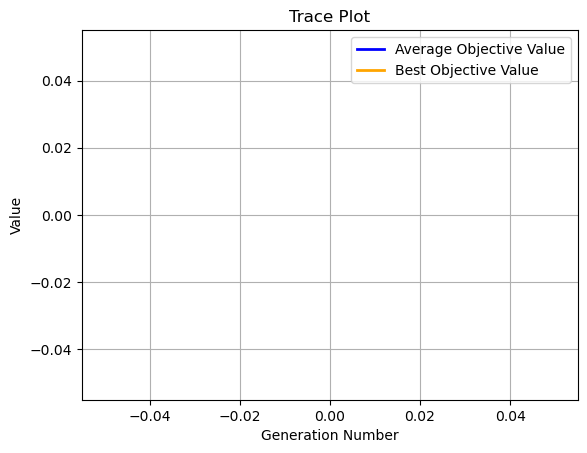

Execution time: 1.3028740882873535 s
Evaluation number: 1000000
Optimization fail: Could not find any feasible solution.


TypeError: can't multiply sequence by non-int of type 'NoneType'

In [62]:
import geatpy as ea

flattened_time_diffs = [item for sublist in time_diffs for item in sublist]
flattened_var_candidates = [item for sublist in var_candidates for item in sublist]
# Use geatpy to solve the problem: choose one number from each inner_list of time_diffs, and make the variance of the chosen numbers least
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self):
        name = 'MyProblem' # 初始化name（函数名称，可以随意设置）
        M = 1 # 初始化M（目标维数）
        maxormins = [1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = len(flattened_time_diffs) # 初始化Dim（决策变量维数）
        varTypes = [1] * Dim # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Dim # 决策变量下界
        ub = [1] * Dim # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界
        ubin = [1] * Dim # 决策变量上边界
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    def evalVars(self, Vars):
        # Calcualte the variance of the chosen time_diffs
        chosen_time_diffs = Vars * flattened_time_diffs
        #print(chosen_time_diffs)
        non_zero_matrix = np.where(chosen_time_diffs == 0, np.nan, chosen_time_diffs)
        
        #print(mean)
        variance = np.nanvar(non_zero_matrix, axis=1).reshape(-1, 1) # 计算目标函数值，赋值给pop种群对象的ObjV属性
        # print(variance)
        cv_list1 = []
        count_num = 0
        for idx, inner_list in enumerate(time_diffs):
            _cv = abs(np.sum(Vars[:, count_num:count_num+len(inner_list)], axis=1) - 1).reshape(-1, 1)
            count_num += len(inner_list)
            cv_list1.append(_cv)
        
        cv_list2 = []
        for eta_idx in set(flattened_var_candidates):
            _indices = np.where(np.array(flattened_var_candidates) == eta_idx)[0]
            _cv = abs(np.sum(Vars[:, np.where(np.array(flattened_var_candidates) == eta_idx)[0]], axis=1) - 1).reshape(-1, 1)
            cv_list2.append(_cv)
        # cv1 = (np.sum(Vars[:, [0, 5, 8, 13, 18]], axis=1) - 2).reshape(-1, 1)
        # cv2 = (np.sum(Vars[:, [1, 6, 9, 14, 19]], axis=1) - 2).reshape(-1, 1)
        # cv3 = (np.sum(Vars[:, [2, 7, 10, 15, 20]], axis=1) - 2).reshape(-1, 1)
        # cv4 = (np.sum(Vars[:, [3, 11, 16, 21]], axis=1) - 2).reshape(-1, 1)
        # cv5 = (np.sum(Vars[:, [4, 12, 17, 22]], axis=1) - 2).reshape(-1, 1)
        # cv_list2 = [cv1, cv2, cv3, cv4, cv5]
        
        cv = np.hstack(cv_list1+cv_list2) 
        return variance, cv
    
problem = MyProblem()
algorithm = ea.soea_DE_best_1_bin_templet(problem, ea.Population(Encoding='RI', NIND=1000),
        MAXGEN=1000)
algorithm.mutOper.F = 0.5  # 差分进化中的参数F
algorithm.recOper.XOVR = 0.7  # 重组概率
# 求解
res = ea.optimize(algorithm,
                  verbose=True,
                  drawing=1,
                  outputMsg=True,
                  drawLog=False,
                  )# 最大进化代数。)# 实例化一个算法模板对象

res['Vars'] * flattened_time_diffs

In [51]:
var_candidates

[[0, 1, 2, 3, 4], [0, 1, 2], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]

In [95]:
np.var(np.array([2,5,8,3,8]))

6.16

In [94]:
np.var(res['Vars'] * flattened_time_diffs)

8.76923076923077

In [100]:
c = res['Vars'] * flattened_time_diffs
c = np.where(c == 0, np.nan, c)
np.nanvar(c)

6.16

In [29]:
b = [1, 2, 3, 4, 5]
_ = [1, 313, 414, 4141, 1]
a = np.array([[1, 0, 3, 4, 5],
             [6, 7, 0, 9, 10],
              [11, 0, 13, 14, 15],
             [16, 17, 18, 19, 0]])
a

array([[ 1,  0,  3,  4,  5],
       [ 6,  7,  0,  9, 10],
       [11,  0, 13, 14, 15],
       [16, 17, 18, 19,  0]])

In [30]:
a[:, 1:3]

array([[ 0,  3],
       [ 7,  0],
       [ 0, 13],
       [17, 18]])

In [145]:
a[:, np.where(np.array(_) == 1)[0]]

array([[ 1,  5],
       [ 6, 10],
       [11, 15],
       [16,  0]])

In [102]:
d = np.where(a == 0, np.nan, a)
d

array([[ 1., nan,  3.,  4.,  5.],
       [ 6.,  7., nan,  9., 10.],
       [11., nan, 13., 14., 15.],
       [16., 17., 18., 19., nan]])